In [12]:
%reload_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
from astropy.coordinates import AltAz, SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates.angles import Angle

from astropy.time import Time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [38]:
_Lon = (106. + 51./60. + 24.0/3600.) * u.deg
_Lat = (25. + 39./60. + 10.6/3600.) * u.deg
_Location = EarthLocation.from_geodetic(_Lon, _Lat)

def get_pointing_any_scan(time, alt0, az0, time_format='unix', feed_rotation=0):
    
    '''
    estimate the pointing RA Dec accoriding obs time and init Dec 
    for drift scan pointing at meridian
    
    time: obs time
    '''

    if alt0 > 90.: alt0=90.
    za0  = 90. - alt0
    za0 = np.float64((za0 * u.deg).to(u.radian).value)
    az0 = np.float64((az0 * u.deg).to(u.radian).value)

    # position of 19 beam in unit or arcmin, from Wenkai's calculation
    # already rotated by 23.4 deg
    x_position = np.array([  0.000,   5.263,   0.659,  -4.604,  -5.263,
                            -0.659,   4.604,  10.526,   5.922,   1.318,
                            -3.945,  -9.208,  -9.867, -10.526,  -5.922,
                            -1.318,   3.945,   9.208,   9.867], dtype='float64')
    y_position = np.array([  0.000,  -2.277,  -5.6965, -3.419,   2.277,
                             5.6965,  3.419,  -4.555,  -7.974, -11.393,
                             -9.116, -6.838,  -1.142,   4.555,   7.974,
                             11.393,  9.116,   6.838,   1.142], dtype='float64')

    separation = np.sqrt(x_position ** 2 + y_position ** 2) * u.arcmin
    position_angle  = np.arctan2(x_position, y_position) * u.rad - 23.4 * u.deg
    position_angle += feed_rotation * u.deg
    
    separation = separation.to(u.radian).value
    position_angle = position_angle.to(u.radian).value
    position_angle += az0
    position_angle[position_angle > np.pi] -= 2. * np.pi
    position_angle[position_angle < -np.pi] += 2. * np.pi
    #for i in range(19):
    #    print '%2d'%(i+1), '%12.6f'%(position_angle[i] * 180./np.pi), \
    #          '%12.6f'%((position_angle[i] + az0) * 180./np.pi)
    
    sign = (position_angle) / np.abs(position_angle)
    
    position_angle[0] = 0.
    separation[0] = 0.

    za = np.cos(za0) * np.cos(separation) + np.sin(za0) * np.sin(separation) * np.cos(position_angle)
    za = np.arccos(za)
    
    if za0 != 0:
        daz = (- np.cos(za0) * np.cos(za) + np.cos(separation)) / np.sin(za0)/ np.sin(za)
    
        daz[daz<-1] = -1
        daz[daz>1]  = 1
        #print daz.min(), daz.max()
        daz = np.arccos(daz) * sign
        
    else:
        daz = position_angle - 2 * az0

    az = Angle(az0 + daz, u.radian) 
    za = Angle(za, u.radian)
    alt = 90.*u.deg - za
    
    #for i in range(19):
    #    print '%3d'%i, '%3dd%3dm%6.2fs'%alt[i].dms,  '%6dd%3dm%6.2fs'%az[i].dms
    
    
    _t, _alt, _az = np.broadcast_arrays(time[:, None], alt[None, :].deg, az[None, :].deg)
    _t = Time(_t, format=time_format, location=_Location)
    _alt = Angle(_alt, u.deg)
    _az  = Angle(_az,  u.deg)
    c0   = SkyCoord(alt=_alt, az=_az, frame='altaz', location=_Location, obstime=_t)
    c0   = c0.transform_to('icrs')
    

    return az.deg, alt.deg, c0.ra.deg, c0.dec.deg

def project_to_antenna_coord(alt, az, alt0=None, az0=None):
    
    if alt0 is None: alt0 = alt[0]
    if az0  is None: az0  = az[0]
    y = alt - alt0
    x = (az  - az0) * np.cos(alt * np.pi / 180.)
    
    return x, y

def _get_meridian_transit_time(obstime, location, target):
    
    altaz_frame = AltAz(obstime=obstime, location=location)
    
    target_altaz = target.transform_to(altaz_frame)
    close_points = np.abs(target_altaz.alt.deg - 90.).argmin()
    
    return obstime[close_points]

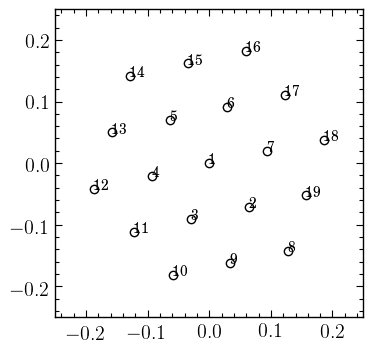

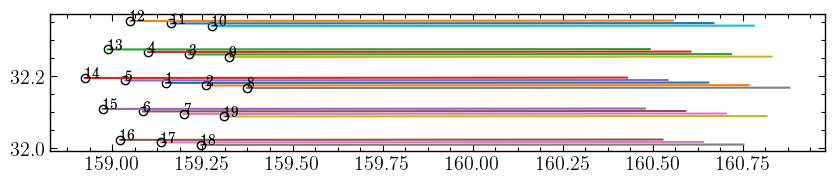

In [6]:
'''
Test coord
'''
# assume some time and pointing
time = Time('2020-05-05 12:00:00') + np.linspace(0, 0.1, 100) * u.hour
alt0  = 80.
az0   = 48.

# get pointing of each beam
az, alt, ra, dec = get_pointing_any_scan(time.unix, alt0, az0, feed_rotation=0)

# plot beam coord in ant. coord
fig = plt.figure(figsize=[4, 4])
ax  = fig.add_subplot(111)
x, y = project_to_antenna_coord(alt, az)
for i in range(19):
    ax.plot(x[i], y[i], 'ko', mfc='none')
    ax.text(x[i], y[i], '%2d'%(i+1))
ax.set_aspect('equal')
ax.set_xlim(-0.25, 0.25)
ax.set_ylim(-0.25, 0.25)

# plot beam coord in RA Dec coord
# with alt0 lower than 80 and az!=0 or 180, beams in the same line are scanning different dec
fig = plt.figure(figsize=[10, 6])
ax  = fig.add_subplot(111)
for i in range(19):
    ax.plot(ra[:, i], dec[:, i])
    ax.plot(ra[0, i], dec[0, i], 'ko', mfc='none')
    ax.text(ra[0, i], dec[0, i], '%2d'%(i+1))

ax.set_aspect('equal')

Cal meridian transit time: 2020-05-06T15:24:58.909(UTC)
Start time around 2020-05-06T13:54:38.909(UTC)
----------------------------------------------------------------------------------------------------
  #                         Time         Beam1 Pointing Alt Az         Beam1 Pointing RA Dec
  0 2020-05-06T13:55:48.909(UTC), ( 70d 2m21.4035s,  71d48m3.96s); ( 13h29m58.03s,  30d18m9.97s)
  1 2020-05-06T14:03:08.909(UTC), ( 71d36m25.3722s,  71d 0m57.33s); ( 13h29m58.03s,  30d19m23.86s)
  2 2020-05-06T14:10:28.909(UTC), ( 73d 9m42.2145s,  69d56m1.92s); ( 13h29m58.03s,  30d21m51.65s)
  3 2020-05-06T14:17:48.909(UTC), ( 74d42m27.0327s,  68d37m15.35s); ( 13h29m58.03s,  30d23m5.54s)
  4 2020-05-06T14:25:08.909(UTC), ( 76d11m43.7077s,  66d19m52.88s); ( 13h29m58.03s,  30d33m3.90s)
  5 2020-05-06T14:32:28.909(UTC), ( 77d41m37.5038s,  64d 2m28.62s); ( 13h29m58.03s,  30d34m17.79s)
  6 2020-05-06T14:39:48.909(UTC), ( 79d 8m56.0990s,  60d54m30.24s); ( 13h29m58.03s,  30d36m45.57s)
  7 2020-05-06T

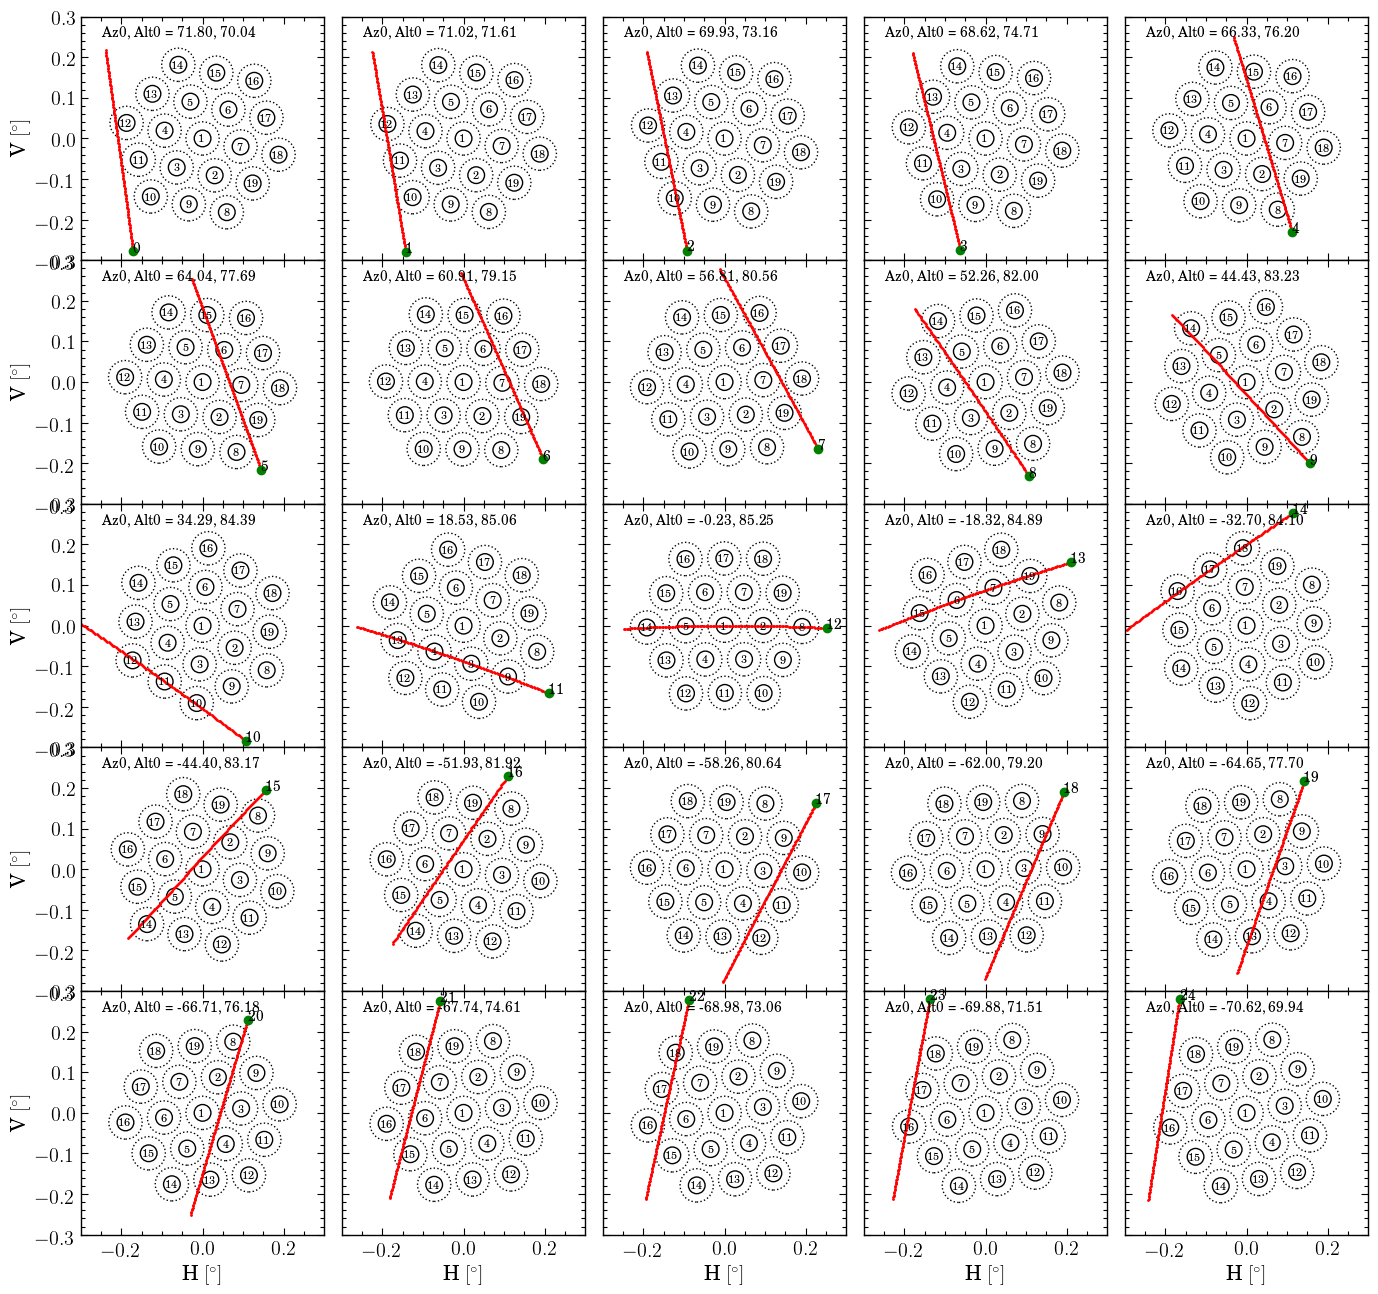

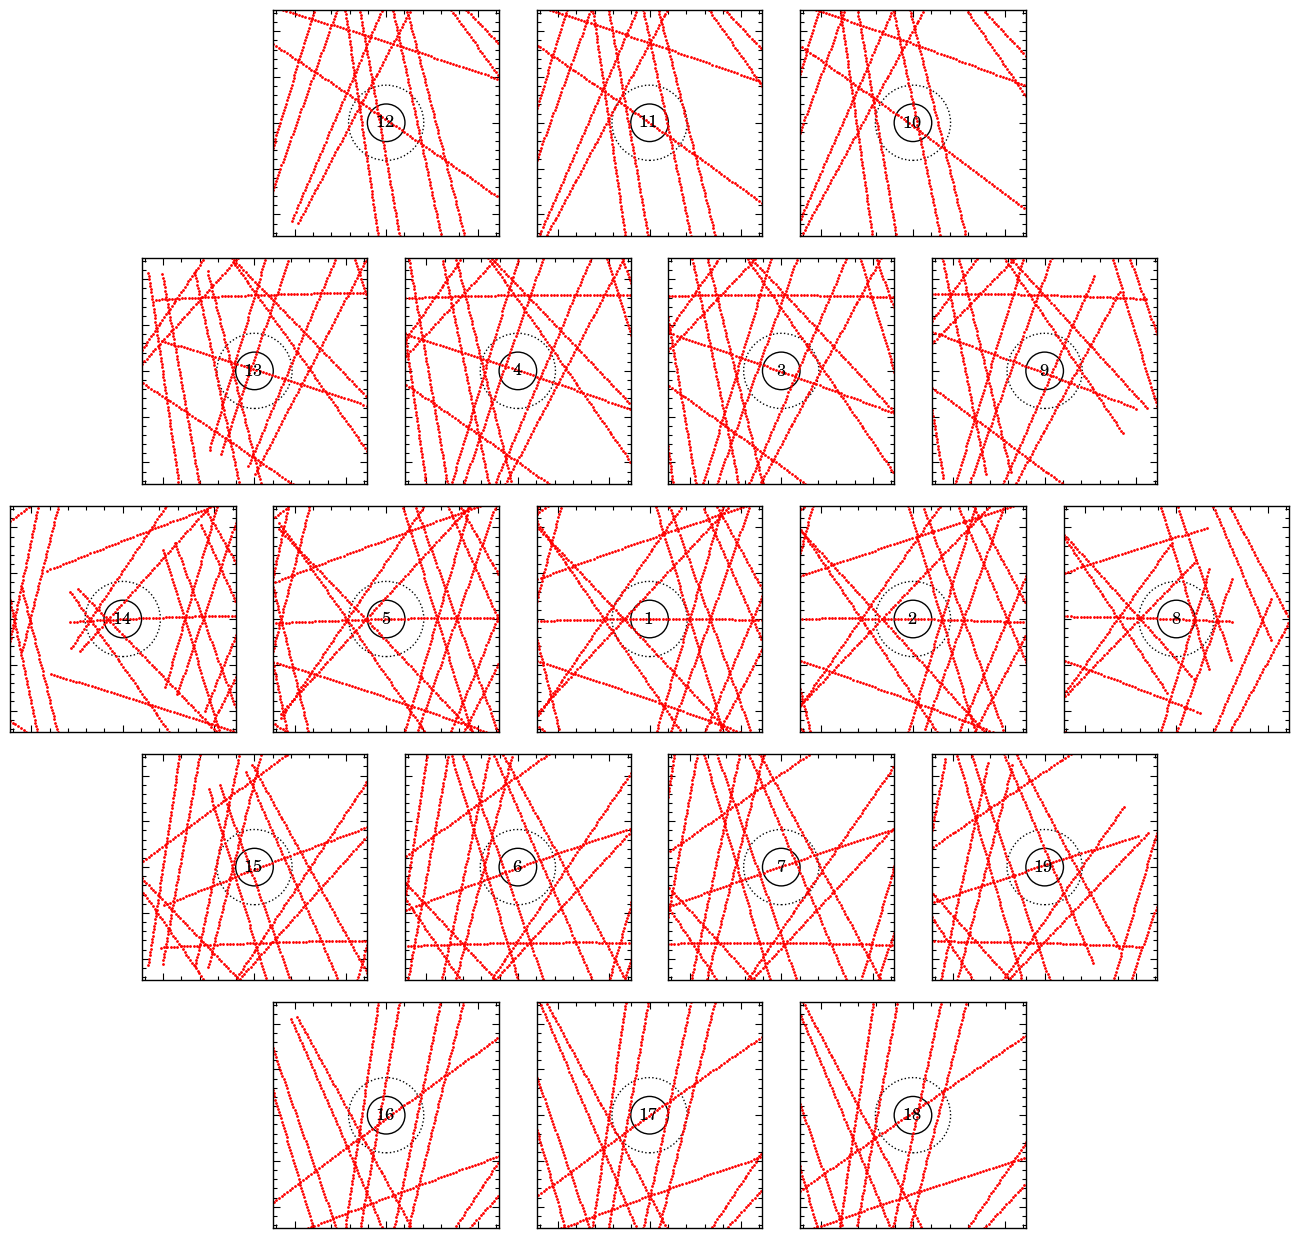

In [54]:
# simulate calibrator scans. 3C286

cal_ra  = Angle('13h31m08.287984s')
cal_dec = Angle('30d30m32.958850s') #+ ddec * u.deg
cal = SkyCoord(cal_ra, cal_dec)
_obstime = Time('2020-05-06 6:00:00') + np.linspace(0, 18, 100) * u.hour
time_transit = _get_meridian_transit_time(_obstime, _Location, cal)
_obstime = time_transit + np.linspace(-0.18, 0.18, 100) * u.hour
time_transit = _get_meridian_transit_time(_obstime, _Location, cal)
print 'Cal meridian transit time: %s'%time_transit.fits

# loading_time is the time duration for beam re-position, need to check with observer.
loading_time = 5 * u.minute


start_time = time_transit - 12. * (loading_time + 140 * u.second)
print 'Start time around %s'%(start_time - 140 * u.second).fits


# Dec shift for beam scanning. 
#
# line_space: The space between different beam line is 4.96625 arcmin, according to the beam position.
# See calculation in the last block of this notebook
#
# line_shift: Each beam line is scanned for 5 times with shift of beam size fwhm/2/sqrt(2ln2)
#
# ddec_list: The order of the scanning is special designed to have better coverage for each beam.
#
fwhm = 2.9 / 60. / (2. * np.log(2.))**0.5 # this is actually the sigma.
line_space = (Angle('0d9m55.95s') / 2.).deg
line_shift = fwhm / 2.
ddec_list = [
    #-2*line_space - 3.*line_shift,
    -2*line_space - 2.*line_shift, 
    -2*line_space - 1.*line_shift,
    #-2*line_space, 
    -2*line_space + 1.*line_shift,
    -2*line_space + 2.*line_shift,
    
    line_space - 2.*line_shift, 
    line_space - 1.*line_shift,
    #line_space, 
    line_space + 1.*line_shift,
    line_space + 2.*line_shift,
    
    - 2.*line_shift, 
    - 1.*line_shift,
    
    -2*line_space,
    -line_space,
    0, 
    line_space,
    2*line_space,
    
    + 1.*line_shift,
    + 2.*line_shift,
    
    -line_space - 2.*line_shift, 
    -line_space - 1.*line_shift,
    #line_space,
    -line_space + 1.*line_shift,
    -line_space + 2.*line_shift,
    

    2*line_space - 2.*line_shift, 
    2*line_space - 1.*line_shift,
    #2*line_space,
    2*line_space + 1.*line_shift,
    2*line_space + 2.*line_shift,
    #2*line_space + 3.*line_shift,
    ]


n_scans = len(ddec_list)
n_col = 5
n_row = int(np.ceil(n_scans / float(n_col)))
fig = plt.figure(figsize=[15, 14])
gs = gridspec.GridSpec(n_row , n_col, 
                       left=0.08, bottom=0.08, right=0.95, top=0.95, wspace=0.0, hspace=0.0)

fig2 = plt.figure(figsize=[15, 14])
gs2  = gridspec.GridSpec(5 , 10, 
                     left=0.08, bottom=0.08, right=0.95, top=0.95, wspace=0.1, hspace=0.1)
ax2 = []
ax2.append(fig2.add_subplot(gs2[2, 4:6]))

ax2.append(fig2.add_subplot(gs2[2, 6:8]))
ax2.append(fig2.add_subplot(gs2[1, 5:7]))
ax2.append(fig2.add_subplot(gs2[1, 3:5]))
ax2.append(fig2.add_subplot(gs2[2, 2:4]))
ax2.append(fig2.add_subplot(gs2[3, 3:5]))
ax2.append(fig2.add_subplot(gs2[3, 5:7]))

ax2.append(fig2.add_subplot(gs2[2, 8:10]))
ax2.append(fig2.add_subplot(gs2[1, 7:9]))
ax2.append(fig2.add_subplot(gs2[0, 6:8]))
ax2.append(fig2.add_subplot(gs2[0, 4:6]))
ax2.append(fig2.add_subplot(gs2[0, 2:4]))
ax2.append(fig2.add_subplot(gs2[1, 1:3]))
ax2.append(fig2.add_subplot(gs2[2, 0:2]))
ax2.append(fig2.add_subplot(gs2[3, 1:3]))
ax2.append(fig2.add_subplot(gs2[4, 2:4]))
ax2.append(fig2.add_subplot(gs2[4, 4:6]))
ax2.append(fig2.add_subplot(gs2[4, 6:8]))
ax2.append(fig2.add_subplot(gs2[3, 7:9]))


dt = 140. * u.second + loading_time
#for ii, ddec in enumerate(np.linspace(-0.22, 0.22, n_scans)):
print '-'*100
print '%3s%29s%30s%30s'%('#', 'Time', 'Beam1 Pointing Alt Az', 'Beam1 Pointing RA Dec')
for ii, ddec in enumerate(ddec_list):
    
    ax = fig.add_subplot(gs[ii//n_col, ii - ii//n_col * n_col])

    time = Time(start_time) + np.arange(-70, 70, 1) * u.second + dt * ii
    mid = len(time) // 2
    #print mid, len(time)

    #print '%3d %3dh%2dm%6.4fs  %3dd%2dm%6.4fs '%((ii, ) + cal_ra.hms + cal_dec.dms)
    
    obs = AltAz(location=_Location, obstime = time)
    cal_altaz = cal.transform_to(obs)
    cal_alt, cal_az = cal_altaz.alt.deg, cal_altaz.az.deg
    cal_az[cal_az>180] -= 360.
    cal_az[cal_az<-180] += 360.
    
    # pointing offset 
    p_ra = Angle('13h31m08.287984s')
    p_dec = Angle('30d30m32.958850s') + ddec * u.deg
    p = SkyCoord(p_ra, p_dec)
    p_altaz = p.transform_to(obs)
    p_alt, p_az = p_altaz.alt.deg, p_altaz.az.deg
    p_az[p_az>180] -= 360
    p_az[p_az<-180] += 360
    alt0 = p_alt[mid]
    az0  = p_az[mid]
    az, alt, ra, dec = get_pointing_any_scan(time.unix, alt0, az0, feed_rotation=0)
    
    ra_c  = Angle(ra[0, 0], u.deg)
    dec_c = Angle(dec[0, 0], u.deg)
    az_c  = Angle(az[0], u.deg)
    alt_c = Angle(alt[0], u.deg)
    print '%3d %s, (%3dd%2dm%4.4fs, %3dd%2dm%4.2fs);'%((ii, time[0].fits) + alt_c.dms + az_c.dms)\
         +' (%3dh%2dm%4.2fs, %3dd%2dm%4.2fs)'%(ra_c.hms + dec_c.dms)
    
    cal_x, cal_y = project_to_antenna_coord(cal_alt, cal_az, alt0, az0)
    x, y = project_to_antenna_coord(alt, az, alt0, az0)
    
    
    for i in range(19):
        #ax.plot(x[i], y[i], 'ko', mfc='none')
        ax.add_artist(plt.Circle((x[i], y[i]), fwhm/2., color='k', fill=False))
        ax.add_artist(plt.Circle((x[i], y[i]), fwhm, color='k', linestyle=':', fill=False))
        ax.text(x[i], y[i], '%d'%(i+1), ha='center', va='center', size=8)
        
        #ax2[i].scatter(ra[:, i], dec[:, i], s=5, c='r', edgecolors='none', alpha=0.1)
        cal_xi, cal_yi = project_to_antenna_coord(cal_alt, cal_az, alt[i], az[i])
        ax2[i].plot(cal_xi, cal_yi, 'r.', ms=2)
        #ax2[i].plot(cal_xi[0], cal_yi[0], 'go')
        #ax2[i].text(cal_xi[0], cal_yi[0], '%2d'%ii)
    
    ax.text(-0.25, 0.25, 'Az0, Alt0 = %5.2f, %5.2f' % (az0, alt0))

    ax.plot(cal_x, cal_y, 'r.', ms=2)
    ax.plot(cal_x[0], cal_y[0], 'go')
    ax.text(cal_x[0], cal_y[0], '%2d'%ii)
    ax.set_aspect('equal')
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
    if ii // n_col == n_row - 1:
        ax.set_xlabel(r'H $[^\circ]$')
    else:
        ax.set_xticklabels([])
    if ii - ii//n_col * n_col == 0:
        ax.set_ylabel(r'V $[^\circ]$')
    else:
        ax.set_yticklabels([])
    #ax.set_title('Ant. Coord.')

for i, _ax in enumerate(ax2):
    #_ax.plot(cal_ra.deg, cal_dec.deg, 'kx', zorder=1000)
    _ax.add_artist(plt.Circle((0, 0), fwhm/2., color='k', fill=False))
    _ax.add_artist(plt.Circle((0, 0), fwhm, color='k', linestyle=':', fill=False))
    _ax.text(0, 0, '%d'%(i+1), ha='center', va='center', size=12)
    _ax.set_aspect('equal')
    #_ax.set_xlim(xmin=cal_ra.deg - 0.5, xmax=cal_ra.deg + 0.5)
    #_ax.set_ylim(ymin=cal_dec.deg - 0.5, ymax=cal_dec.deg + 0.5)
    _ax.set_xlim(xmin=-3*fwhm, xmax=3*fwhm)
    _ax.set_ylim(ymin=-3*fwhm, ymax=3*fwhm)
    _ax.set_xticklabels([])
    _ax.set_yticklabels([])

In [59]:
'''
test beam position
'''
x_position = np.array([  0.000,   5.263,   0.659,  -4.604,  -5.263,
                        -0.659,   4.604,  10.526,   5.922,   1.318,
                        -3.945,  -9.208,  -9.867, -10.526,  -5.922,
                        -1.318,   3.945,   9.208,   9.867])
y_position = np.array([  0.000,  -2.277,  -5.6965, -3.419,   2.277,
                         5.6965,  3.419,  -4.555,  -7.974, -11.393,
                        -9.1160, -6.838,  -1.142,   4.555,   7.974,
                         11.393,  9.116,   6.838,   1.142])

separation = np.sqrt(x_position ** 2 + y_position ** 2) * u.arcmin
position_angle  = np.arctan2(x_position, y_position) * u.rad - 23.4 * u.deg
position_angle[0]
for i in range(19):
    a = Angle(separation[i])
    b = Angle(position_angle[i])
    print '%2d'%(i+1), '%3dd%3dm%6.2fs (%7.4f arcmin)'%(a.dms + (a.arcmin,)), '%6dd%3dm%6.2fs'%b.dms

 1   0d  0m  0.00s ( 0.0000 arcmin)    -23d-23m-60.00s
 2   0d  5m 44.07s ( 5.7344 arcmin)     89d 59m 43.38s
 3   0d  5m 44.07s ( 5.7345 arcmin)    150d  0m  3.84s
 4   0d  5m 44.08s ( 5.7347 arcmin)   -149d-59m-53.30s
 5   0d  5m 44.07s ( 5.7344 arcmin)    -90d  0m-16.62s
 6   0d  5m 44.07s ( 5.7345 arcmin)    -29d-59m-56.16s
 7   0d  5m 44.08s ( 5.7347 arcmin)     30d  0m  6.70s
 8   0d 11m 28.16s (11.4693 arcmin)     89d 59m 59.89s
 9   0d  9m 55.95s ( 9.9325 arcmin)    120d  0m  0.25s
10   0d 11m 28.14s (11.4690 arcmin)    150d  0m  3.84s
11   0d  9m 55.98s ( 9.9330 arcmin)   -179d-59m-57.05s
12   0d 11m 28.16s (11.4693 arcmin)   -149d-59m-53.30s
13   0d  9m 55.97s ( 9.9329 arcmin)   -120d  0m -7.20s
14   0d 11m 28.16s (11.4693 arcmin)    -90d  0m -0.11s
15   0d  9m 55.95s ( 9.9325 arcmin)    -59d-59m-59.75s
16   0d 11m 28.14s (11.4690 arcmin)    -29d-59m-56.16s
17   0d  9m 55.98s ( 9.9330 arcmin)      0d  0m  2.95s
18   0d 11m 28.16s (11.4693 arcmin)     30d  0m  6.70s
19   0d  9